In [28]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [30]:
from datetime import datetime

# Load actors with score

In [31]:
actors = pd.read_csv('fomc_scorecard.csv', sep=";", index_col=3, header=0)
actors = actors[actors['Score'] != 0]

# Load articles

In [32]:
from pymongo import MongoClient

In [33]:
client = MongoClient('localhost', 27017)
fomc_collection = client.python_import.fomc_articles

In [34]:
fomc_articles = pd.DataFrame(list(fomc_collection.find()))
fomc_articles.set_index('_id', inplace=True)

# Merge articles and actors score

In [35]:
fomc_articles_scored = fomc_articles.merge(actors, left_on='ParticipantName', right_index=True)
fomc_articles_scored.head(2)

,ParticipantJobTitle,ParticipantLocation,ParticipantName,ParticipantTitleLastName,ParticipantUrl,RemarkDate,RemarkDescription,RemarkType,content,date,url,Name,Score,Shifted score
_id,,,,,,,,,,,,,,
58cab2973740f50f2c6fdccb,Pres.,Richmond,Jeffrey Lacker,Pres. Lacker,/fomcspeak/jeffrey-lacker,"Dec. 03, 2013",Lacker Testifies on Bankruptcy and Financial I...,Testimony,Good morning. I am honored to speak to the Sub...,2013-12-03 00:00:00,https://www.richmondfed.org/press_room/speeche...,Jeffrey M. Lacker,2,4
58cab29e3740f50f2c6fdcce,Pres.,Richmond,Jeffrey Lacker,Pres. Lacker,/fomcspeak/jeffrey-lacker,"Apr. 18, 2013 (8:06 AM ET)",Fed's Lacker Would End QE Now,Video Interview,Fed's Lacker Would End QE Now\n\t\t\t\t\n In a...,2013-04-18 08:06:00,http://video.cnbc.com/gallery/?video=3000162414,Jeffrey M. Lacker,2,4


# Number of articles in each score class

In [9]:
fomc_articles_scored.groupby('Score')['url'].count()

Score
-2    148
-1    168
 1    150
 2     72
Name: url, dtype: int64

# Create train data and test data

In [36]:
train_data = fomc_articles_scored[fomc_articles_scored['date'] < datetime(2016, 6, 1)]
test_data = fomc_articles_scored[fomc_articles_scored['date'] >= datetime(2016, 6, 1)]

In [37]:
X_train = train_data['content']
y_train = train_data['Score']
X_test = test_data['content']
y_test = test_data['Score']

# Tf-Idf and LogisticRegression model

### GridSearch on pipeline - it takes 20+ minutes on my machine!!!!!!!
###### http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_digits.html

In [12]:
pipeline = Pipeline([
    ('bow', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer(norm='l2')),
    ('logreg_model', LogisticRegression())
])
#pipeline.fit(X_train, y_train)

params = dict(bow__ngram_range=[(1,1), (1,2), (1,3)],
              bow__max_df=np.arange(0.1,0.4,0.1),
              bow__min_df=[2,3,4],
              logreg_model__C=np.arange(0.5, 1.5, 0.3))
grid_search = GridSearchCV(pipeline, 
                           param_grid=params, 
                           verbose=3, 
                           scoring='precision_macro', 
                           n_jobs=8,
                           refit=True,
                           cv=5)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   15.7s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:  3.1min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  7.0min
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed: 13.6min
[Parallel(n_jobs=8)]: Done 720 out of 720 | elapsed: 20.0min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('bow', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        s...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=8,
       param_grid={'bow__ngram_range': [(1, 1), (1, 2), (1, 3)], 'bow__max_df': array([ 0.1,  0.2,  0.3,  0.4]), 'bow__min_df': [2, 3, 4], 'logreg_model__C': array([ 0.5,  0.8,  1.1,  1.4])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='precision_macro', verbose=3)

In [13]:
grid_search.best_params_

{'bow__max_df': 0.40000000000000002,
 'bow__min_df': 3,
 'bow__ngram_range': (1, 2),
 'logreg_model__C': 1.1000000000000001}

In [14]:
grid_search.best_score_

0.85486294717787159

### Fitting the model

In [38]:
pipeline = Pipeline([
    ('bow', CountVectorizer(stop_words='english', max_df=0.4, min_df=3, ngram_range=(1,2))),
    ('tfidf', TfidfTransformer(norm='l2')),
    ('bayes_model', LogisticRegression(C=1.1))
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('bow', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.4, max_features=None, min_df=3,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        s...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [39]:
y_predicted = pipeline.predict(X_test)

#### Confusion matrix
By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
is equal to the number of observations known to be in group :math:`i` but
predicted to be in group :math:`j`.

In [40]:
cm = confusion_matrix(y_test, y_predicted)

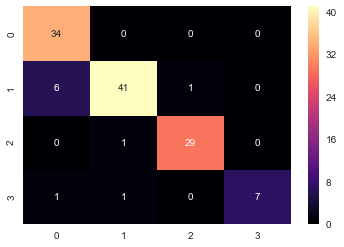

In [41]:
sns.heatmap(cm, cmap='magma', annot=True)

In [42]:
cr = classification_report(y_test, y_predicted)
print(cr)

             precision    recall  f1-score   support

         -2       0.83      1.00      0.91        34
         -1       0.95      0.85      0.90        48
          1       0.97      0.97      0.97        30
          2       1.00      0.78      0.88         9

avg / total       0.93      0.92      0.92       121



# Playground

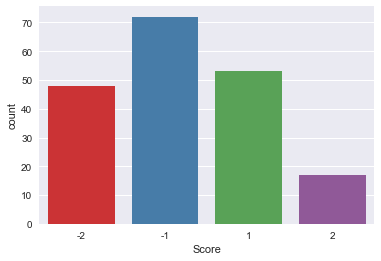

In [20]:
sns.countplot(y_test, palette="Set1")

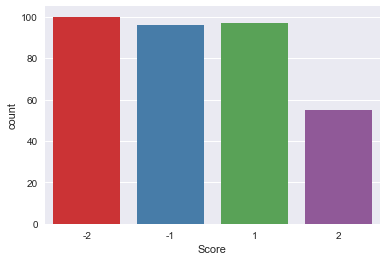

In [21]:
sns.countplot(y_train, palette="Set1")